In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
%config Completer.use_jedi = False # 配置kaggle使用代码提示
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognition-data/sample_submission.csv
/kaggle/input/digit-recognition-data/digi-recog-train.csv
/kaggle/input/digit-recognition-data/digit-recog-test.csv


In [2]:
!nvidia-smi

Fri Aug  8 01:06:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8             11W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import torch

print(torch.cuda.is_available())

True


In [4]:
!pip show sklearn

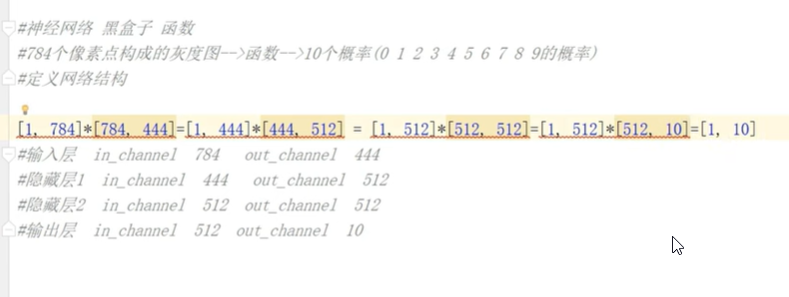

In [5]:

# 用代码搭建神经网络
import torch
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(784,444),
    nn.ReLU(), #使用ReLU函数作为激活函数
    nn.Linear(444,512),
    nn.ReLU(),
    nn.Linear(512,512),
    nn.ReLU(),
    nn.Linear(512,10),
    nn.Softmax()
)

print(model)

Sequential(
  (0): Linear(in_features=784, out_features=444, bias=True)
  (1): ReLU()
  (2): Linear(in_features=444, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=512, bias=True)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=10, bias=True)
  (7): Softmax(dim=None)
)


In [6]:
# 上面的模型的w和b是随机值不好用,我们需要对他进行训练,但是在训练之前,我们需要来验证一下这个模型是否合理,
# 也就是输入784个特征,是否能够达到10个概率
data = torch.rand(1,784)
pred = model(data)
print(pred) # 得到10个概率,说明我们的模型搭建合理


tensor([[0.1019, 0.0946, 0.0976, 0.1029, 0.1009, 0.1028, 0.1000, 0.0933, 0.1047,
         0.1013]], grad_fn=<SoftmaxBackward0>)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [7]:
# 训练模型
import pandas as pd

# 读取数据
data = pd.read_csv("/kaggle/input/digit-recognition-data/digi-recog-train.csv")
# data
# 整理数据划分标签和特征
#标签
label = data["label"].values
# label
#特征,需要获取特征,只需要把label这一列删除即可
data = data.drop(['label'],axis=1)
# data
features = data.values
